In [43]:
# =============================
# Cell 1 — Imports
# =============================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump, load

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
# =============================
# Cell 2 — Configuration
# =============================
DATA_DIR = "D:/University/AI/Project/Alzheimer Speech Detection/data"
CSV_PATH = os.path.join(DATA_DIR, "addetector_dataset.csv")
MODEL_DIR = "D:/University/AI/Project/Alzheimer Speech Detection/models"
RESULTS_DIR = "D:/University/AI/Project/Alzheimer Speech Detection/results"
RANDOM_STATE = 42

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [45]:
# =============================
# Cell 3 — Load & Inspect Data
# =============================
df = pd.read_csv(CSV_PATH)
df = df.dropna()
print("Data shape after dropping missing values:", df.shape)
X = df.drop(columns=['label'])
y = df['label']

print("Feature shape:", X.shape, "Labels shape:", y.shape)
print("Unique labels:", y.unique())

Data shape after dropping missing values: (1010, 66)
Feature shape: (1010, 65) Labels shape: (1010,)
Unique labels: [1 0]


In [46]:

# =============================
# Cell 4 — Train/Test Split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [47]:
# =============================
# Cell 5 — Feature Scaling
# =============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
dump(scaler, os.path.join(MODEL_DIR, "scaler.joblib"))

['D:/University/AI/Project/Alzheimer Speech Detection/models\\scaler.joblib']

Random Forest — Accuracy: 0.5396, F1-score: 0.2185
              precision    recall  f1-score   support

           0       0.55      0.86      0.67       112
           1       0.45      0.14      0.22        90

    accuracy                           0.54       202
   macro avg       0.50      0.50      0.45       202
weighted avg       0.51      0.54      0.47       202



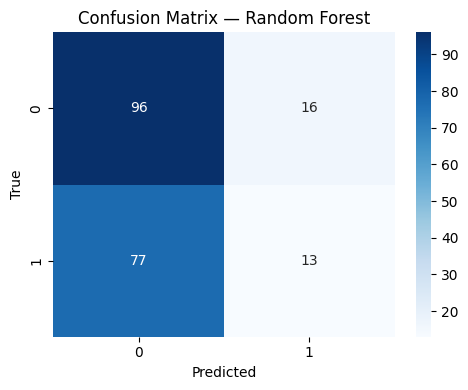

['D:/University/AI/Project/Alzheimer Speech Detection/models\\rf_alz_model.joblib']

In [48]:

# =============================
# Cell 6 — Random Forest
# =============================
# Handle class imbalance
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest — Accuracy: {acc_rf:.4f}, F1-score: {f1_rf:.4f}")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix_rf.png"))
plt.show()

dump(rf, os.path.join(MODEL_DIR, "rf_alz_model.joblib"))

In [49]:

# =============================
# Cell 7 — Neural Network
# =============================
nn_model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate NN
y_prob_nn = nn_model.predict(X_test_scaled).flatten()
nn_threshold = 0.6  # adjustable to reduce false positives
y_pred_nn = (y_prob_nn > nn_threshold).astype(int)

acc_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
print(f"Neural Network — Accuracy: {acc_nn:.4f}, F1-score: {f1_nn:.4f}")
print(classification_report(y_test, y_pred_nn))

nn_model.save(os.path.join(MODEL_DIR, "nn_alz_model.h5"))

c:\Users\m\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.5000 - loss: 0.7578 - val_accuracy: 0.5062 - val_loss: 0.7192
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5263 - loss: 0.6998 - val_accuracy: 0.5247 - val_loss: 0.7084
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6115 - loss: 0.6471 - val_accuracy: 0.5370 - val_loss: 0.7108
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6300 - loss: 0.6378 - val_accuracy: 0.5370 - val_loss: 0.7107
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6579 - loss: 0.6243 - val_accuracy: 0.5617 - val_loss: 0.7181
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6889 - loss: 0.5954 - val_accuracy: 0.5679 - val_loss: 0.7235
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7136 - loss: 0.5751 - val_accuracy: 0.5679 - val_loss: 0.7248
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7121 - loss: 0.5627 - val_accuracy: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Neural Network — Accuracy: 0.5743, F1-score: 0.1731
              precision    recall  f1-score   support

           0       0.57      0.96      0.71       112
           1       0.64      0.10      0.17        90

    accuracy                           0.57       202
   macro avg       0.61      0.53      0.44       202
weighted avg       0.60      0.57      0.47       202



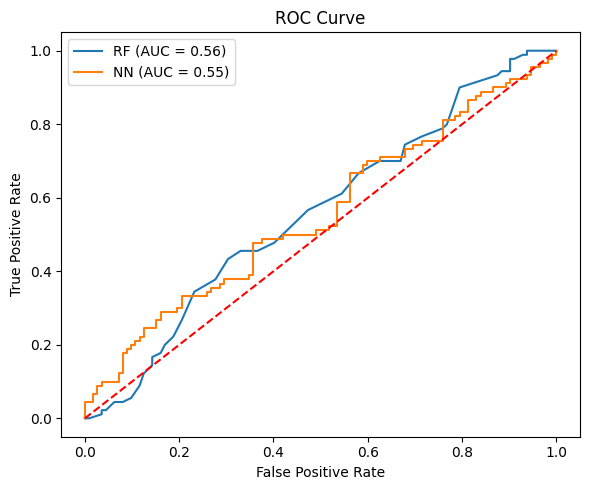

In [50]:
# =============================
# Cell 8 — ROC Curve
# =============================
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'NN (AUC = {roc_auc_nn:.2f})')
plt.plot([0,1],[0,1],'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "roc_curve.png"))
plt.show()


In [51]:

# =============================
# Cell 9 — Ensemble Prediction Function
# =============================
def predict_alzheimer(features_raw, scaler, rf_model, nn_model, rf_threshold=0.6, nn_threshold=0.6):
    """
    Input: features_raw -> 1D numpy array of length 65
    Returns: final prediction label ('Healthy' or 'Alzheimer') and confidences
    """
    # Scale features
    features_scaled = scaler.transform([features_raw])

    # Random Forest
    rf_prob = rf_model.predict_proba(features_scaled)[0][1]
    rf_pred = int(rf_prob > rf_threshold)

    # Neural Network
    nn_prob = nn_model.predict(features_scaled)[0][0]
    nn_pred = int(nn_prob > nn_threshold)

    # Ensemble: majority vote with confidence tie-break
    if rf_pred != nn_pred:
        final_pred = rf_pred if rf_prob > nn_prob else nn_pred
    else:
        final_pred = rf_pred

    label_map = {0: "Healthy", 1: "Alzheimer"}
    return label_map[final_pred], rf_prob, nn_prob

In [52]:
"""
# =============================
# Cell 10 — Simple Neural Network
# =============================
os.makedirs("D:/University/AI/Alzheimer Speech Detection/results", exist_ok=True)

num_classes = len(y.unique())
y_train_nn = to_categorical(y_train)
y_test_nn = to_categorical(y_test)

model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)
"""

'\n# =============================\n# Cell 10 — Simple Neural Network\n# =============================\nos.makedirs("D:/University/AI/Alzheimer Speech Detection/results", exist_ok=True)\n\nnum_classes = len(y.unique())\ny_train_nn = to_categorical(y_train)\ny_test_nn = to_categorical(y_test)\n\nmodel = Sequential([\n    Dense(128, input_shape=(X_train_scaled.shape[1],), activation=\'relu\'),\n    Dropout(0.3),\n    Dense(64, activation=\'relu\'),\n    Dropout(0.3),\n    Dense(num_classes, activation=\'softmax\')\n])\n\nmodel.compile(optimizer=\'adam\', loss=\'categorical_crossentropy\', metrics=[\'accuracy\'])\nmodel.summary()\n\n# Early stopping\nes = EarlyStopping(monitor=\'val_loss\', patience=10, restore_best_weights=True)\n\nhistory = model.fit(\n    X_train_scaled, y_train_nn,\n    validation_split=0.2,\n    epochs=100,\n    batch_size=16,\n    callbacks=[es],\n    verbose=1\n)\n'

In [53]:
"""
# =============================
# Cell 11 — Evaluate Neural Network
# =============================
loss, acc = model.evaluate(X_test_scaled, y_test_nn)
print(f"🎯 Neural Network Accuracy: {acc:.4f}")

# Confusion Matrix
y_pred_nn = np.argmax(model.predict(X_test_scaled), axis=1)
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix — Neural Network")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("D:/University/AI/Project/Alzheimer Speech Detection/results/confusion_matrix_nn.png")
plt.show()

# Plot training history
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training History — Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("D:/University/AI/Project/Alzheimer Speech Detection/results/training_history_nn.png")
plt.show()

model.save("D:/University/AI/Project/Alzheimer Speech Detection/models/nn_alz_model.h5")
print("✅ Neural Network model saved!")
"""

'\n# =============================\n# Cell 11 — Evaluate Neural Network\n# =============================\nloss, acc = model.evaluate(X_test_scaled, y_test_nn)\nprint(f"🎯 Neural Network Accuracy: {acc:.4f}")\n\n# Confusion Matrix\ny_pred_nn = np.argmax(model.predict(X_test_scaled), axis=1)\ncm = confusion_matrix(y_test, y_pred_nn)\nplt.figure(figsize=(5, 4))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Purples\')\nplt.title("Confusion Matrix — Neural Network")\nplt.xlabel("Predicted")\nplt.ylabel("True")\nplt.tight_layout()\nplt.savefig("D:/University/AI/Project/Alzheimer Speech Detection/results/confusion_matrix_nn.png")\nplt.show()\n\n# Plot training history\nplt.figure(figsize=(6, 4))\nplt.plot(history.history[\'accuracy\'], label=\'Train Acc\')\nplt.plot(history.history[\'val_accuracy\'], label=\'Val Acc\')\nplt.title("Training History — Neural Network")\nplt.xlabel("Epochs")\nplt.ylabel("Accuracy")\nplt.legend()\nplt.tight_layout()\nplt.savefig("D:/University/AI/Project/Alzheimer

In [54]:
"""
# =============================
# Cell 13 — Save Accuracies
# =============================


accuracies = {
    "random_forest": acc_rf,
    "neural_network": acc
}

os.makedirs("D:/University/AI/Project/Alzheimer Speech Detection/models", exist_ok=True)
with open("D:/University/AI/Project/Alzheimer Speech Detection/models/accuracies.json", "w") as f:
    json.dump(accuracies, f)

print("✅ Model accuracies saved to ../models/accuracies.json")
"""

'\n# =============================\n# Cell 13 — Save Accuracies\n# =============================\n\n\naccuracies = {\n    "random_forest": acc_rf,\n    "neural_network": acc\n}\n\nos.makedirs("D:/University/AI/Project/Alzheimer Speech Detection/models", exist_ok=True)\nwith open("D:/University/AI/Project/Alzheimer Speech Detection/models/accuracies.json", "w") as f:\n    json.dump(accuracies, f)\n\nprint("✅ Model accuracies saved to ../models/accuracies.json")\n'